# Exercise 2 - Zaremba small model on Penn Treebank
## Stav Bar-Sheshet and Shlomo Spitzer

# Load Data

## Mount Drive
To load PTB, save and load the trained model

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
!ls "drive/My Drive/Deep Learning Course/ex2_301558086_305143315/PTB"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
lstm.with_drop.history	     shlomogru_with_drop_model.hdf5
matar			     shlomogru.with_drop.model.weights.best.hdf5
ptb.char.test.txt	     shlomogru.without_drop.history
ptb.char.train.txt	     shlomogru_without_drop_model.hdf5
ptb.char.valid.txt	     shlomogru.without_drop.model.weights.best.hdf5
ptb.test.txt		     shlomolstm.with_drop.history
ptb.train.txt		     shlomolstm_with_drop_model.hdf5
ptb.valid.txt		     shlomolstm.with_drop.model.weights.best.hdf5

## Load PTB from Github
Another option to load the PTB data without mounting the drive

In [0]:
!git clone https://github.com/wojzaremba/lstm.git
!ls "lstm/data"

Cloning into 'lstm'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (53/53), done.
ptb.test.txt  ptb.train.txt  ptb.valid.txt


# Initialize

## Data Preprocessing
PTB data path is defined under 'data_path'.

read_words - convert the PTB text files to lists.

build_vocab - create a dictionary which represent each words in the training set with an id number.

file_to_word_ids - convert a list of words to their ids using the vocabulary dictionary.

load_data - create the training, validation and testing sets using the functions above. In addition, a reverse dictionary is created, in order to check the trained model id prediction results back as words.


In [2]:
from __future__ import print_function
import collections
import csv
import os
import tensorflow as tf
from time import time
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed, Reshape
from keras.layers import LSTM, GRU, CuDNNLSTM, CuDNNGRU
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical, get_custom_objects
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback, CSVLogger, TensorBoard
from keras.initializers import RandomUniform
from keras import backend as K
from keras import metrics as M
import pandas as pd
import numpy as np

data_path = "drive/My Drive/Deep Learning Course/ex2_301558086_305143315/PTB/"
# data_path = "lstm/data/"

def read_words(filename):
    with tf.gfile.GFile(filename, "r") as f:
        return f.read().replace("\n", "<eos>").split()


def build_vocab(filename):
    data = read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))

    return word_to_id


def file_to_word_ids(filename, word_to_id):
    data = read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]


def load_data():
    # get the data paths
    train_path = os.path.join(data_path, "ptb.train.txt")
    valid_path = os.path.join(data_path, "ptb.valid.txt")
    test_path = os.path.join(data_path, "ptb.test.txt")

    # build the complete vocabulary, then convert text data to list of integers
    word_to_id = build_vocab(train_path)
    train_data = file_to_word_ids(train_path, word_to_id)
    valid_data = file_to_word_ids(valid_path, word_to_id)
    test_data = file_to_word_ids(test_path, word_to_id)
    vocabulary = len(word_to_id)
    reversed_dictionary = dict(zip(word_to_id.values(), word_to_id.keys()))

    print('Training data as id example:')
    print(train_data[:5],'\n\n')
    print('Word dictionary:')
    print(word_to_id,'\n\n')
    print('Number of words (in the training set only):')
    print(vocabulary,'\n\n')
    print('Reverse training id examples to words:')
    print(" ".join([reversed_dictionary[x] for x in train_data[:5]]))
    return train_data, valid_data, test_data, vocabulary, reversed_dictionary

train_data, valid_data, test_data, vocabulary, reversed_dictionary = load_data()

Using TensorFlow backend.


Training data as id example:
[9970, 9971, 9972, 9974, 9975] 


Word dictionary:
{'the': 0, '<unk>': 1, '<eos>': 2, 'N': 3, 'of': 4, 'to': 5, 'a': 6, 'in': 7, 'and': 8, "'s": 9, 'that': 10, 'for': 11, '$': 12, 'is': 13, 'it': 14, 'said': 15, 'on': 16, 'by': 17, 'at': 18, 'as': 19, 'from': 20, 'million': 21, 'with': 22, 'mr.': 23, 'was': 24, 'be': 25, 'are': 26, 'its': 27, 'he': 28, 'but': 29, 'has': 30, 'an': 31, "n't": 32, 'will': 33, 'have': 34, 'new': 35, 'or': 36, 'company': 37, 'they': 38, 'this': 39, 'year': 40, 'which': 41, 'would': 42, 'about': 43, 'says': 44, 'more': 45, 'were': 46, 'market': 47, 'billion': 48, 'his': 49, 'had': 50, 'their': 51, 'up': 52, 'u.s.': 53, 'one': 54, 'than': 55, 'who': 56, 'some': 57, 'been': 58, 'also': 59, 'stock': 60, 'other': 61, 'share': 62, 'not': 63, 'we': 64, 'corp.': 65, 'if': 66, 'when': 67, 'i': 68, 'last': 69, 'president': 70, 'shares': 71, 'years': 72, 'all': 73, 'first': 74, 'two': 75, 'because': 76, 'trading': 77, 'after': 78, 'could':

## Training Object Definition

An instance of the set is defined of a nummber of consecutive words. The instance is defined as a class object.

The object posess the following arguments, data, num_steps, batch_size (defined in the model), vocabulary (number of word in the dictionary - 10000), current_idx and skip_step.

The current_idx is used to make sure that all the data is extracted from the data set, since each set is of a different size. When all the data is extracted from the set, the index is set to 0. 

The class constructor is a python generator which creates a list of num_steps input and output (x and y ) instances. A generator allows to iterate the list once and then release it from the memory. This makes the training more memory efficient. 





In [0]:
class BatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps))
#         y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                y[i, :] = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
                self.current_idx += self.skip_step
            yield x, y

##Perplexity Definition

Peplexity is used to measure the network's accuracy. Perplexity is simply calculated by power e by the loss. The base e is used since TF used a natural logarithm to calculate the cross entropy.
The mean of the loss must be calculated in order to get right results.

schedule - is a function used to control the learning rate same as in Zaremba et al. The lr in the small model is reduced by 1.2 factor in 4th epoch and after.

In [0]:
def sparse_categorical_crossentropy_from_logits(y_true, y_pred):  
    return K.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

def perplexity(y_true, y_pred):  
    return K.exp(K.mean(sparse_categorical_crossentropy_from_logits(y_true, y_pred)))
# for some reason this gives wrong values - different from calculating e^cross_entropy
  
def schedule(epoch, lr):
  if epoch + 1  >= 4: # here epochs count from 0
    lr = lr / 2.
  return lr

## Model Construction and fitting

The model is based on Zaremba et al. 2015

The "medium" model is used, which has 35 steps (words), minibatches of 20 input sequences and 650 neurons per layer. In the exrecise, 200 neurons are defined.

model_constructor - uses to construct either an LSTM or a GRU model, with or without Dropout regulirization.

The regulirization was used as in Zambera et al., which is applying a p=0.5 dropout only on the non-recurrent connections. 

Both the learning rate and dropout probability measures can be changed by the user.

perplexity - uses to calculate the loss as done in Zambera et al. and defined in the exercise.

fitting - gets the net and fitting parameters, fit the network and return the best fitted model and the fitting history.

In [0]:
def model_constructor(train_data, valid_data, vocabulary, net, num_steps, hidden_size, lr, drp):
    zaremba_init = RandomUniform(minval=-0.1, maxval=0.1)

    model = Sequential()
    model.add(Embedding(vocabulary, hidden_size, input_length=num_steps, embeddings_initializer=zaremba_init))
    if drp > 0.:
        model.add(Dropout(drp))
    if net == 'lstm':
      model.add(CuDNNLSTM(hidden_size, return_sequences=True, kernel_initializer=zaremba_init))
      if drp > 0.:
        model.add(Dropout(drp))
      model.add(CuDNNLSTM(hidden_size, return_sequences=True, kernel_initializer=zaremba_init))
    else:
      model.add(CuDNNGRU(hidden_size, return_sequences=True, kernel_initializer=zaremba_init))
      if drp > 0.:
        model.add(Dropout(drp))
      model.add(CuDNNGRU(hidden_size, return_sequences=True, kernel_initializer=zaremba_init))
    if drp > 0.:
        model.add(Dropout(drp))      
    model.add(Dense(vocabulary, kernel_initializer=zaremba_init))
    model.add(Activation('linear'))
    
#     zaremba_opt = SGD(lr, momentum=0.0, decay=0.0, nesterov=False, clipnorm = 5.)
    zaremba_opt = Adam(lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm = 5.)    
  

    model.compile(loss=sparse_categorical_crossentropy_from_logits , optimizer=zaremba_opt, metrics=[perplexity])

    print(model.summary())
      
    return model
  
def fitting(train_data, valid_data, vocabulary, data_path, name = 'Stav/', net='lstm', num_epochs = 2, lr=0.001, drp = 0.5, num_steps=35, batch_size=20, hidden_size=200):
  
    train_data_generator = BatchGenerator(train_data, num_steps, batch_size, vocabulary,
                                               skip_step=num_steps)
    valid_data_generator = BatchGenerator(valid_data, num_steps, batch_size, vocabulary,
                                               skip_step=num_steps)
    
    model = model_constructor(train_data, valid_data, vocabulary, net, num_steps, hidden_size, lr, drp)
    
    
    if drp > 0.:
      drop='with_drop'
    else:
      drop='without_drop'
    
#     model = load_model(data_path + name + net + '_' + drop + "_model.hdf5", custom_objects={'perplexity': perplexity})

    change_opt = LearningRateScheduler(schedule, verbose=1)
    checkpointer = ModelCheckpoint(filepath= data_path + name + net+'.'+drop+'.model.weights.best.hdf5', verbose = 1, save_best_only=True)
    csv_logger = CSVLogger(filename = data_path + name + net+'.'+drop+'.history.csv', separator=',', append=False) #stream epoc results
    tb_plot = TensorBoard(log_dir='./log/'+name + net +'.'+drop, histogram_freq=0,
                         write_graph=False,
                         write_grads=False,
                         batch_size=batch_size,
                         write_images=True)

    history = model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,
                                  validation_data=valid_data_generator.generate(),
                                  validation_steps=len(valid_data)//(batch_size*num_steps),
                                  callbacks=[checkpointer, csv_logger, tb_plot])

    model.save(data_path + name+ net + '_' + drop + "_model.hdf5")
    
    return history

## Check Model and Results

check - gets the fitted model and present the prediction results using the reveresed dictionary.

plot_acc_loss - gets the fitting history and and plots the **perplexity** and loss for both the training and validation sets.

In [0]:
def check(data_set, num_steps, vocabulary, reversed_dictionary, model):
    dummy_iters = 40
    example_generator = BatchGenerator(data_set, num_steps, 1, vocabulary,
                                                     skip_step=1)
    for i in range(dummy_iters):
        dummy = next(example_generator.generate())
    num_predict = 10
    true_print_out = "Actual words: "
    pred_print_out = "Predicted words: "
    for i in range(num_predict):
        data = next(example_generator.generate())
        prediction = model.predict(data[0])
        predict_word = np.argmax(prediction[:, num_steps-1, :])
        true_print_out += reversed_dictionary[data_set[num_steps + dummy_iters + i]] + " "
        pred_print_out += reversed_dictionary[predict_word] + " "
    print(true_print_out)
    print(pred_print_out)

def check_model(train_data, valid_data, test_data, vocabulary, reversed_dictionary, data_path, name = 'Stav/', net='lstm', drp = 0.5, num_steps=35):
  
    if drp > 0.:
      drop='with_drop'
    else:
      drop='without_drop'
    
    # Load the weights with the best validation accuracy
    model = load_model(data_path + name + net + '_' + drop + "_model.hdf5", custom_objects={'perplexity': perplexity, 'sparse_categorical_crossentropy_from_logits': sparse_categorical_crossentropy_from_logits})
    model.load_weights(data_path + name + net+'.'+drop+'.model.weights.best.hdf5')
    
    train_data_generator = BatchGenerator(train_data, num_steps, batch_size, vocabulary,
                                               skip_step=num_steps)
    valid_data_generator = BatchGenerator(valid_data, num_steps, batch_size, vocabulary,
                                               skip_step=num_steps)
    test_data_generator = BatchGenerator(test_data, num_steps, batch_size, vocabulary,
                                               skip_step=num_steps)
    print('\n',"Training data:")
    check(train_data, num_steps, vocabulary, reversed_dictionary, model)
    print('\n',"Validation data:")
    check(valid_data, num_steps, vocabulary, reversed_dictionary, model)
    print('\n',"Test data:")
    check(test_data, num_steps, vocabulary, reversed_dictionary, model)
    
    # Evaluate the model on test set    
    print('\n','Training set evaluation:')
    train_score = model.evaluate_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), verbose=1)
    print('\n','Validation set evaluation:')
    valid_score = model.evaluate_generator(valid_data_generator.generate(), len(valid_data)//(batch_size*num_steps), verbose=1)
    print('\n','Testing set evaluation:')
    test_score = model.evaluate_generator(test_data_generator.generate(), len(test_data)//(batch_size*num_steps), verbose=1)

    # Print test accuracy
    print('\n','Best Model Results:')
    print('Training set perplexity:', np.exp(train_score[0]))
    print('Validation set perplexity:', np.exp(valid_score[0]))
    print('Testing set perplexity:', np.exp(test_score[0]))
    
import matplotlib.pyplot as plt

def plot_acc_lss(data_path, name = 'Stav/', net='lstm', drp=0.5):
    if drp > 0.:
      drop='with_drop'
    else:
      drop='without_drop'
    csv_file = data_path+name+net+'.'+drop+'.history.csv'
    history = pd.read_csv(csv_file)
    x = range(1, len(history['loss'][:])+1)
    
    # summarize history for accuracy
    plt.plot(x,np.exp(history['loss'][:]))
    plt.plot(x,np.exp(history['val_loss'][:]))
    plt.title(net +' '+drop +' model perplexity')
    plt.ylabel('perplexity')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(x,history['loss'][:])
    plt.plot(x,history['val_loss'][:])
    plt.title(net +' '+drop +' model loss')
    plt.ylabel('sparse_categorical_crossentropy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    
def plot_all(data_path):
  lstm = pd.read_csv(data_path+'/Stav/lstm.without_drop.history.csv')
  lstm_drp = pd.read_csv(data_path+'/Stav/lstm.with_drop.history.csv')
  gru = pd.read_csv(data_path+'/Stav/gru.without_drop.history.csv')
  gru_drp = pd.read_csv(data_path+'/Stav/gru.with_drop.history.csv')
  
  for i in [lstm,lstm_drp,gru,gru_drp]:
    x = range(1, len(i['loss'][:])+1)
    plt.plot(x,np.exp(i['loss'][:]))
  
  plt.title('All Models Training Perplexity')
  plt.ylabel('perplexity')
  plt.xlabel('epoch')
  plt.legend(['LSTM', 'LSTM with Dropout', 'GRU', 'GRU with Dropout'], loc='upper right')
  plt.show()
  
  for i in [lstm,lstm_drp,gru,gru_drp]:
    x = range(1, len(i['val_loss'][:])+1)
    plt.plot(x,np.exp(i['val_loss'][:]))

  plt.title('All Models Validation Perplexity')
  plt.ylabel('perplexity')
  plt.xlabel('epoch')
  plt.legend(['LSTM', 'LSTM with Dropout', 'GRU', 'GRU with Dropout'], loc='upper right')
  plt.show()

## Training Parameters

In [0]:
num_steps=20
batch_size=20
hidden_size=200
name = 'Stav/'

# Training

## Load TensorBoard

In [9]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './log'

get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2018-12-14 17:39:18--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.206.130.40, 34.232.181.106, 34.232.40.183, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.206.130.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]   5.11M  3.44MB/s    in 1.5s    

2018-12-14 17:39:20 (3.44 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
http://75d21a5b.ngrok.io


## LSTM Without Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20, 200)           2000000   
_________________________________________________________________
cu_dnnlstm_17 (CuDNNLSTM)    (None, 20, 200)           321600    
_________________________________________________________________
cu_dnnlstm_18 (CuDNNLSTM)    (None, 20, 200)           321600    
_________________________________________________________________
dense_10 (Dense)             (None, 20, 10000)         2010000   
_________________________________________________________________
activation_10 (Activation)   (None, 20, 10000)         0         
Total params: 4,653,200
Trainable params: 4,653,200
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2323/2323 [==============================] - 65s 28ms/step - loss: 6.2183 - perplexity: 597.6918 - val_loss: 5.7345 

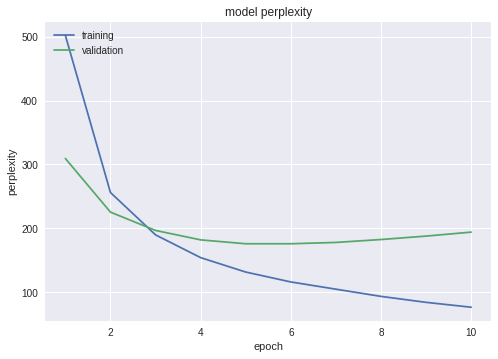

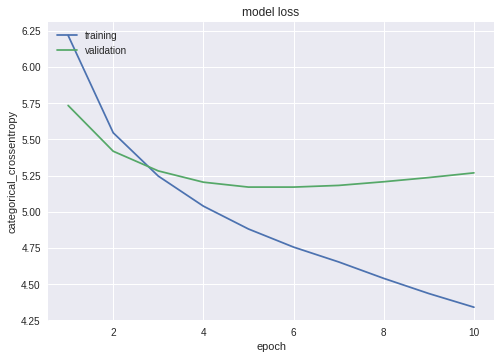

In [27]:
net = 'lstm'
drp = 0.
lr = 0.001
num_epochs = 10
fitting(train_data, valid_data, vocabulary, data_path, name, net, num_epochs, lr, drp, num_steps, batch_size, hidden_size)
check_model(train_data, valid_data, test_data, vocabulary, reversed_dictionary, data_path, name, net, drp, num_steps)
plot_acc_lss(data_path, name, net, drp)


## LSTM With Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 200)           2000000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 20, 200)           321600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 20, 200)           321600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 20, 10000)         2010000   
__________

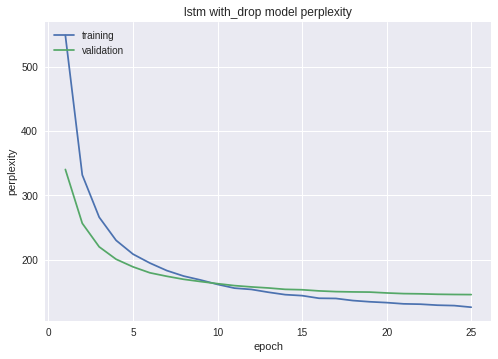

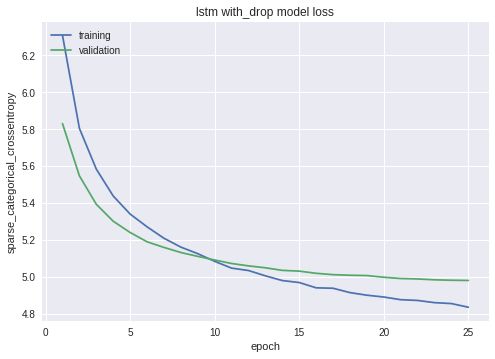

In [12]:
net = 'lstm'
drp = 0.5
lr = 0.001
num_epochs = 25
fitting(train_data, valid_data, vocabulary, data_path, name, net, num_epochs, lr, drp, num_steps, batch_size, hidden_size)
check_model(train_data, valid_data, test_data, vocabulary, reversed_dictionary, data_path, name, net, drp, num_steps)
plot_acc_lss(data_path, name, net, drp)

## GRU Without Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 200)           2000000   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 20, 200)           241200    
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 20, 200)           241200    
_________________________________________________________________
dense_3 (Dense)              (None, 20, 10000)         2010000   
_________________________________________________________________
activation_3 (Activation)    (None, 20, 10000)         0         
Total params: 4,492,400
Trainable params: 4,492,400
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2323/2323 [==============================] - 60s 26ms/step - loss: 6.4837 - perplexity: 751.7979 - val_loss: 5.8085 

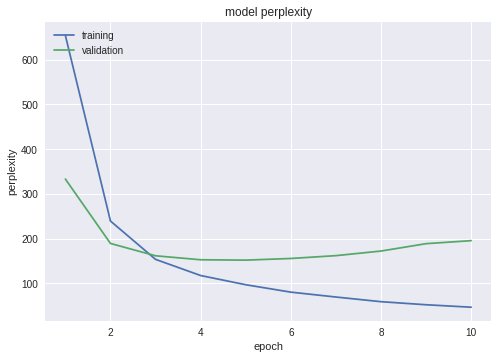

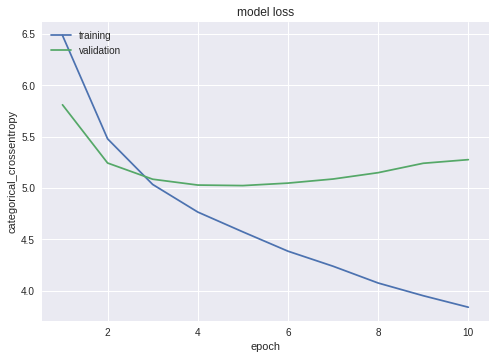

In [11]:
net = 'gru'
drp = 0.0
lr = 0.001
num_epochs = 10
fitting(train_data, valid_data, vocabulary, data_path, name, net, num_epochs, lr, drp, num_steps, batch_size, hidden_size)
check_model(train_data, valid_data, test_data, vocabulary, reversed_dictionary, data_path, name, net, drp, num_steps)
plot_acc_lss(data_path, name, net, drp)

## GRU With Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 20, 200)           241200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 20, 200)           241200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 20, 10000)         2010000   
__________

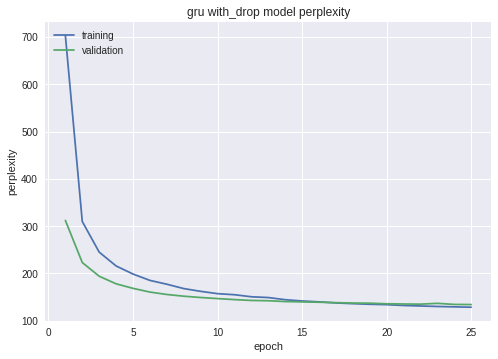

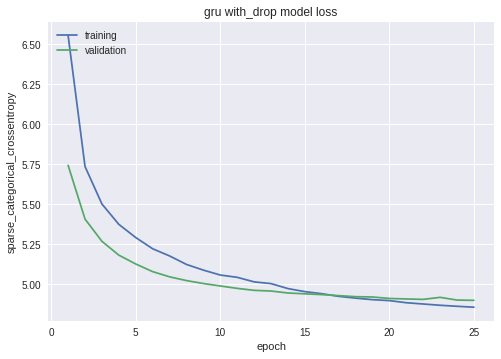

In [11]:
net = 'gru'
drp = 0.5
lr = 0.001
num_epochs = 25
fitting(train_data, valid_data, vocabulary, data_path, name, net, num_epochs, lr, drp, num_steps, batch_size, hidden_size)
check_model(train_data, valid_data, test_data, vocabulary, reversed_dictionary, data_path, name, net, drp, num_steps)
plot_acc_lss(data_path, name, net, drp)

# Load and Evaluate Saved Models
1. Run all code sets in the **Initialize** section above.
2. Mount your **Drive** and define the right **data_path** to the PTB folder, where is the data and trained models are stored.
3. Run the **Check Models** section - this is defined to evaluate all the 4 required models, present a prediction example and the perplexity measure of both the training and testing sets.


## Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

## Specify PTB Data Path

In [0]:
data_path = "drive/My Drive/Deep Learning Course/ex2_301558086_305143315/PTB/"
name = '/Stav'


## Check Models


 Training data:
Actual words: chairman of consolidated gold fields plc was named a nonexecutive 
Predicted words: <unk> of the <unk> inc. said a named president vice 

 Validation data:
Actual words: on various <unk> issues <eos> and the new syndicated reality 
Predicted words: to the <unk> and <eos> the the <unk> <unk> <unk> 

 Test data:
Actual words: unable to cool the selling panic in both stocks and 
Predicted words: <eos> to sell the <unk> of <eos> the <unk> <eos> 

 Training set evaluation:
2323/2323 [==============================] - 21s 9ms/step

 Validation set evaluation:
184/184 [==============================] - 2s 8ms/step

 Testing set evaluation:
206/206 [==============================] - 2s 8ms/step

 Best Model Results:
Training set perplexity: 104.83786632076021
Validation set perplexity: 176.6465873997509
Testing set perplexity: 161.3307326124653


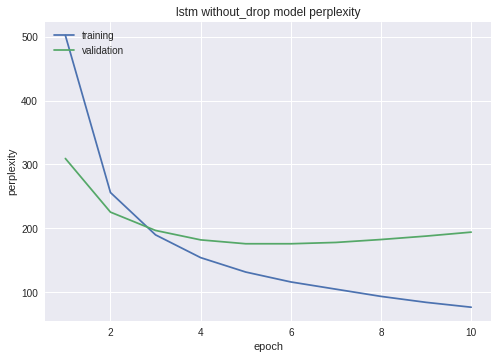

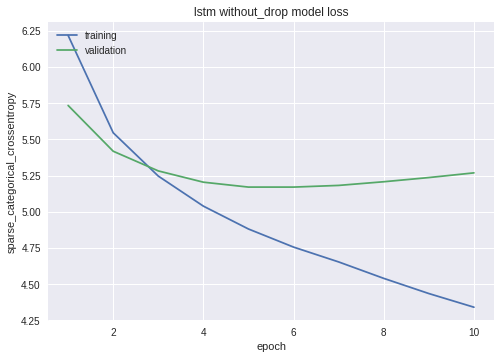


 Training data:
Actual words: chairman of consolidated gold fields plc was named a nonexecutive 
Predicted words: chief of the <unk> corp. said said named president director 

 Validation data:
Actual words: on various <unk> issues <eos> and the new syndicated reality 
Predicted words: to the <unk> <eos> <eos> the the <unk> york <unk> 

 Test data:
Actual words: unable to cool the selling panic in both stocks and 
Predicted words: that to be the <unk> <eos> <eos> the the <eos> 

 Training set evaluation:
2323/2323 [==============================] - 21s 9ms/step

 Validation set evaluation:
184/184 [==============================] - 2s 9ms/step

 Testing set evaluation:
206/206 [==============================] - 2s 9ms/step

 Best Model Results:
Training set perplexity: 91.23830860736506
Validation set perplexity: 148.45721544006113
Testing set perplexity: 135.6020217833227


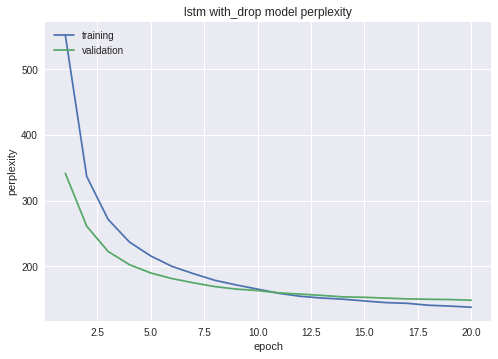

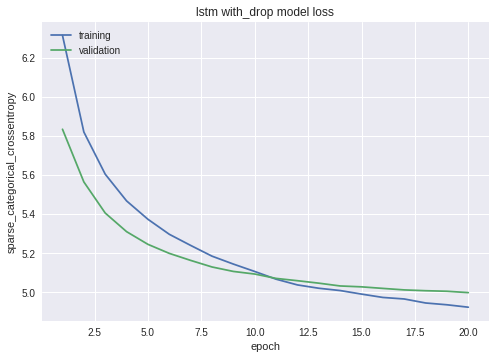


 Training data:
Actual words: chairman of consolidated gold fields plc was named a nonexecutive 
Predicted words: chairman of the <unk> inc. in 's named president director 

 Validation data:
Actual words: on various <unk> issues <eos> and the new syndicated reality 
Predicted words: <eos> the <unk> <unk> <eos> the the <unk> <unk> <unk> 

 Test data:
Actual words: unable to cool the selling panic in both stocks and 
Predicted words: <eos> to sell the market of <eos> the countries <eos> 

 Training set evaluation:
2323/2323 [==============================] - 20s 8ms/step

 Validation set evaluation:
184/184 [==============================] - 2s 8ms/step

 Testing set evaluation:
206/206 [==============================] - 2s 8ms/step

 Best Model Results:
Training set perplexity: 77.60084174982026
Validation set perplexity: 156.01935018144667
Testing set perplexity: 145.84685493798827


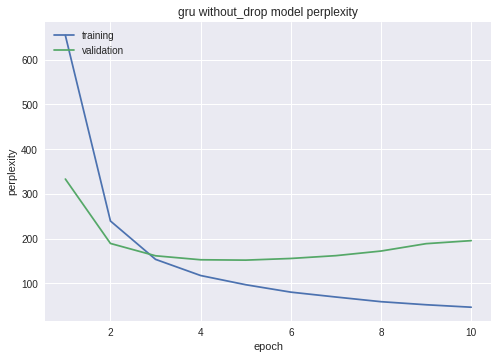

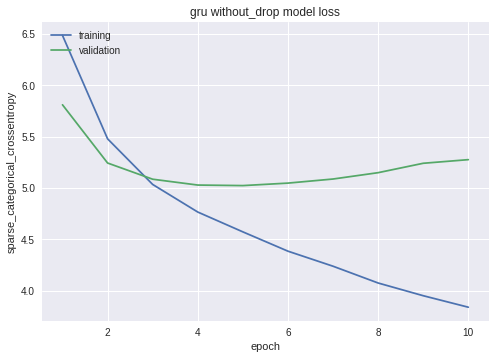


 Training data:
Actual words: chairman of consolidated gold fields plc was named a nonexecutive 
Predicted words: president of the <unk> corp. <eos> of named president director 

 Validation data:
Actual words: on various <unk> issues <eos> and the new syndicated reality 
Predicted words: to the <unk> <eos> <eos> the the <unk> york <unk> 

 Test data:
Actual words: unable to cool the selling panic in both stocks and 
Predicted words: <eos> to be the <unk> <eos> <eos> the <eos> <eos> 

 Training set evaluation:
2323/2323 [==============================] - 21s 9ms/step

 Validation set evaluation:
184/184 [==============================] - 2s 9ms/step

 Testing set evaluation:
206/206 [==============================] - 2s 9ms/step

 Best Model Results:
Training set perplexity: 83.25182922002168
Validation set perplexity: 137.71557288250094
Testing set perplexity: 127.80534956631757


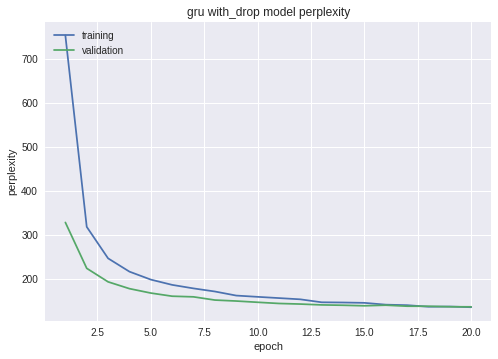

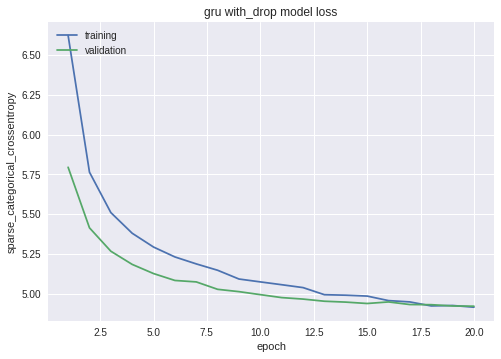

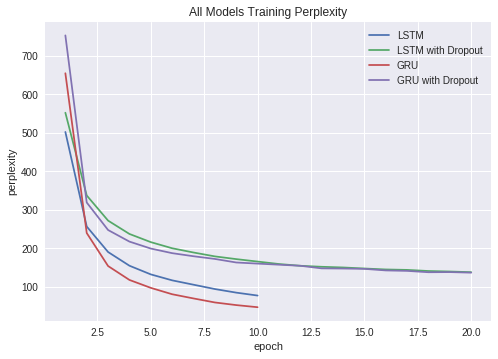

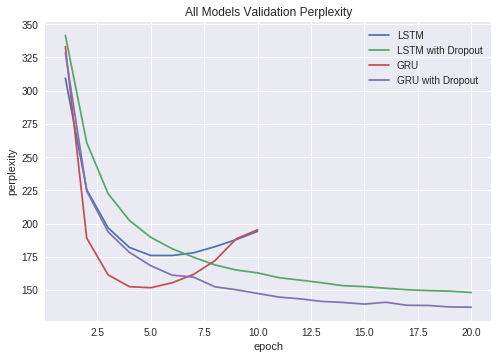

In [10]:
check_model(train_data, valid_data, test_data, vocabulary, reversed_dictionary, data_path, name, net='lstm', drp=0., num_steps=20)
plot_acc_lss(data_path, name, net='lstm', drp=0.)
check_model(train_data, valid_data, test_data, vocabulary, reversed_dictionary, data_path, name, net='lstm', drp=0.3, num_steps=20)
plot_acc_lss(data_path, name, net='lstm', drp=0.5)
check_model(train_data, valid_data, test_data, vocabulary, reversed_dictionary, data_path, name, net='gru', drp=0., num_steps=20)
plot_acc_lss(data_path, name, net='gru', drp=0.)
check_model(train_data, valid_data, test_data, vocabulary, reversed_dictionary, data_path, name, net='gru', drp=0.3, num_steps=20)
plot_acc_lss(data_path, name, net='gru', drp=0.5)
plot_all(data_path)